# MNIST by CNN

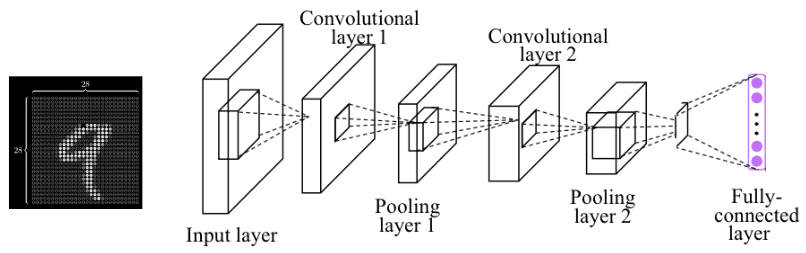

In [74]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


In [75]:
# 랜덤 시드 고정
random.seed(777)
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# MNIST Data

In [76]:
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# Dataset 구성 확인

In [0]:
# MNIST dataset 크기
print("train data 크기:", len(mnist_train), "      ", "test data 크기:",len(mnist_test))

train data 크기: 60000        test data 크기: 10000


In [0]:
# i번째 data 구성 요소확인
i=1234
print(type(mnist_train[i]), len(mnist_train[i]))

<class 'tuple'> 2


In [0]:
first, second= mnist_train[i]
print("first type :", type(first), "       first len :", len(first), "         first size :", first.size())
print("second type :", type(second), "      second :", second)

first type : <class 'torch.Tensor'>        first len : 1          first size : torch.Size([1, 28, 28])
second type : <class 'int'>       second : 3


* 2개의 tuple을 분리하여 first 성분을 확인해보니, 1 x 28 x 28 행렬(image)인 Tensor이고, second는 이 행렬의 Label 정보(정답)을 가지고 있다.

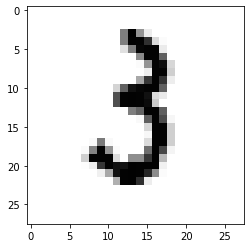

In [0]:
# image가 3차원이므로, 의미없는 1을 없애고 2차원으로 만들기 위해 view(28, 28) 진행하여 image확인
import matplotlib.pyplot as plt

plt.imshow(first.view(28, 28), cmap='Greys', interpolation='nearest')


# Data Loading

In [77]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset=mnist_train, batch_size=100, shuffle=True, drop_last=True)

In [6]:
print(len(data_loader), type(data_loader))

600 <class 'torch.utils.data.dataloader.DataLoader'>


* 전체 크기가 60000개인 data를 100개의 batch_size로 나누므로, data_loader는 600개 data로 구성됨.
* 이 때, data_loader의 한개 data는 자동으로 '100 x input차원'의 행렬이 된다.

# Modeling

In [0]:
#1-1. nn.Sequential 사용하여 Convolution Net 정의
# 이 때 ReLU 함수는 nn.ReLU()를 사용한다.

class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        # ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        # ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7*7*64, 10, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return out

mymodel = CNN().to(device)

In [80]:
# 1-2. Conv. ReLU, Rooling 직접 forward 연산 수행.
# 직접 forward 연산 시, ReLU 함수는 F.relu를 사용한다.
# nn.Sequential 사용에 비해, 계산 효율이 떨어짐.

import torch.nn as nn
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32, kernel_size=3)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3)
        self.mp = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc = torch.nn.Linear(1600, 10, bias=True)  # Linear 함수의 input 차원을 직접계산하지 않더라도,
                                                         # Runtime Error 발생을 통해 그 값을 알 수 있다
        
        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)
        
    def forward(self, x):
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.conv2(x)))         
        x = x.view(x.size(0), -1)   # FC 위해서 Flatten, x.size(0)는 batch size로 이는 고정, 나머지는 펼침.
        x = self.fc(x)
        return x

mymodel = MyModel().to(device)

In [81]:
# 1-3.  MaxPooling과 ReLU 순서 변경했을 경우도 가능하나, cost 및 정확도가 조금 낮아졌음.

import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1,32, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU())
        
        self.fc = nn.Linear(1600, 10, bias=True)
        
        nn.init.xavier_uniform_(self.fc.weight)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

mymodel = MyModel().to(device)

# 학습

In [0]:
# optimizer 정의
learning_rate = 0.001

optimizer = torch.optim.Adam(mymodel.parameters(), lr=learning_rate)

# Cost 정의
criterion = torch.nn.CrossEntropyLoss().to(device)    # 소프트맥스 함수 포함됨.

In [17]:
training_epochs = 15
total_batch = len(data_loader)

for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # image is already size of (28x28), no reshape
        # label is not one-hot encoded
        X = X.to(device)
        Y = Y.to(device)

        hypothesis = mymodel(X)
        cost = criterion(hypothesis, Y)       
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))
    
print('Learning Finished!')

[Epoch:    1] cost = 0.240449324
[Epoch:    2] cost = 0.0697782114
[Epoch:    3] cost = 0.0517999604
[Epoch:    4] cost = 0.0420517698
[Epoch:    5] cost = 0.0350563414
[Epoch:    6] cost = 0.0289513171
[Epoch:    7] cost = 0.0256378558
[Epoch:    8] cost = 0.0216072351
[Epoch:    9] cost = 0.0184865016
[Epoch:   10] cost = 0.0164412428
[Epoch:   11] cost = 0.0144963507
[Epoch:   12] cost = 0.0117196422
[Epoch:   13] cost = 0.00998527929
[Epoch:   14] cost = 0.0088623045
[Epoch:   15] cost = 0.00807926897
Learning Finished!


# Test Data

In [21]:
# 서두에서 mnist_test가 10000개임을 확인했고, j번째 data확인
j=540
print(type(mnist_test[j]), len(mnist_test[j]))

<class 'tuple'> 2


In [22]:
test_first, test_second= mnist_test[j]
print("first type :", type(test_first), "       first len :", len(test_first), "         first size :", test_first.size())
print("second type :", type(test_second), "      second :", test_second)

first type : <class 'torch.Tensor'>        first len : 1          first size : torch.Size([1, 28, 28])
second type : <class 'int'>       second : 5


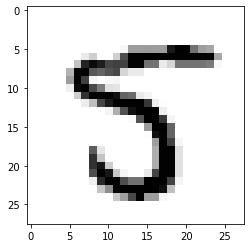

In [23]:
import matplotlib.pyplot as plt

plt.imshow(test_first.view(28, 28), cmap='Greys', interpolation='nearest')

# Model 검증
* 위에서 mnist_test[j]의 image값인 test_first와 Label인 test_second로 model 검증

In [0]:
len(mnist_test)

10000

In [27]:
# 우선 위 mnist_test[j]를 검증
# conv2d의 input 차원은 4차원으로 '배치 크기 × 채널 × 높이× 너비' 로 구성되어야 함.
X_test1 = test_first.view(-1, 1, 28, 28).float().to(device)     # model 함수 input 차원과 맞춤
Y_test1 = test_second

prediction = torch.argmax(mymodel(X_test1),1)
print(prediction)

print(prediction == Y_test1)

tensor([5], device='cuda:0', grad_fn=<NotImplemented>)
tensor([True], device='cuda:0')


* 위에서 test_first 차원 지정없이 다음과 같이 정의하면 RuntimeError 발생하므로, 모르는 batch 차원은 -1로 지정
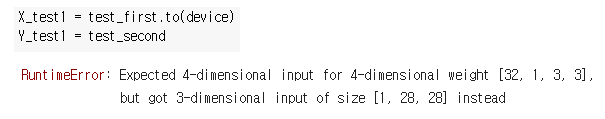

In [ ]:
# minist_test 모든 data에 대해 정확도 통계 계산
# test_data, test_labels method로 전체 data 계산

with torch.no_grad():             # gradient 계산 않음.
    X_test = mnist_test.test_data.view(-1, 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = mymodel(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

# 학습 및 정확도 검증 결과

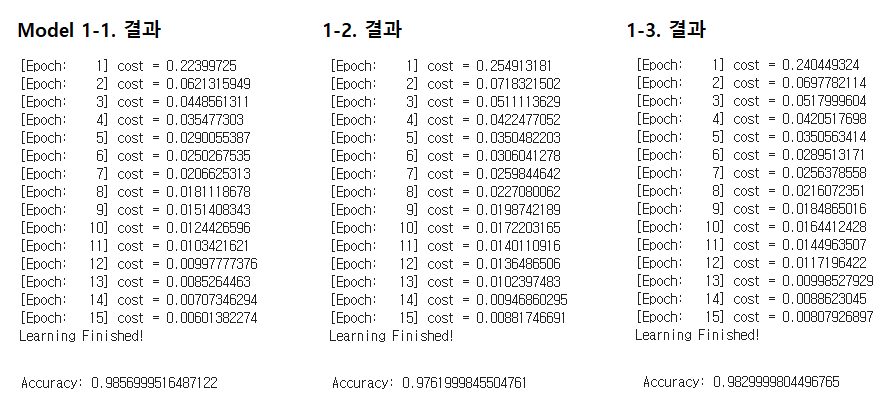

* Reference

 - https://www.youtube.com/watch?v=LgFNRIFxuUo&list=PLlMkM4tgfjnJ3I-dbhO9JTw7gNty6o_2m&index=10
 - https://wikidocs.net/63565